In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# Make plots show inside the notebook
%matplotlib inline


In [17]:
# Load your CSV file
df = pd.read_csv("weather_prediction_dataset (1).csv")

# Look at the first few rows and basic info
print(df.shape)
df.head()


(3654, 165)


,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [18]:
# Create tomorrow's precipitation column by shifting upward by 1
df["HEATHROW_precipitation_tomorrow"] = df["HEATHROW_precipitation"].shift(-1)

# Drop the last row (it has no "tomorrow" value)
df = df.iloc[:-1].copy()

# Binary target: 1 if it will rain tomorrow, 0 if not
df["HEATHROW_rain_tomorrow"] = (df["HEATHROW_precipitation_tomorrow"] > 0).astype(int)

# Check the balance of classes
print(df["HEATHROW_rain_tomorrow"].value_counts())
print(df["HEATHROW_rain_tomorrow"].value_counts(normalize=True))


HEATHROW_rain_tomorrow
1    1855
0    1798
Name: count, dtype: int64
HEATHROW_rain_tomorrow
1    0.507802
0    0.492198
Name: proportion, dtype: float64


In [19]:
feature_cols = [
    "MONTH",
    "HEATHROW_cloud_cover",
    "HEATHROW_humidity",
    "HEATHROW_pressure",
    "HEATHROW_global_radiation",
    "HEATHROW_precipitation",
    "HEATHROW_sunshine",
    "HEATHROW_temp_mean",
    "HEATHROW_temp_min",
    "HEATHROW_temp_max"
]

X = df[feature_cols].copy()
y = df["HEATHROW_rain_tomorrow"].copy()

# Time-based split: first 80% rows for training, last 20% for testing
n = len(df)
split_index = int(0.8 * n)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2922, 10), (731, 10), (2922,), (731,))

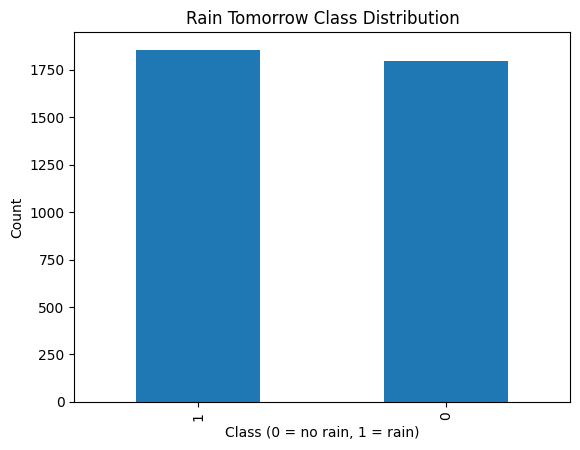

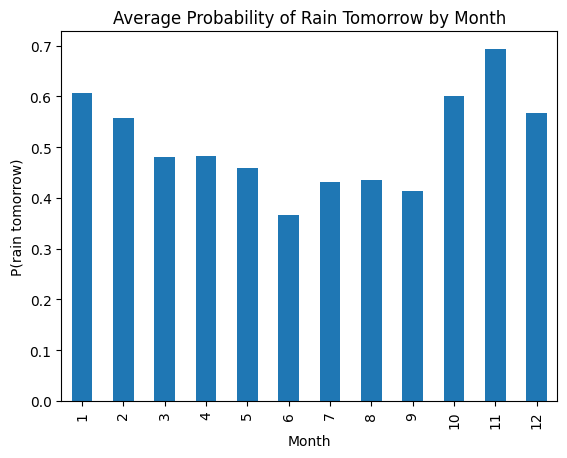

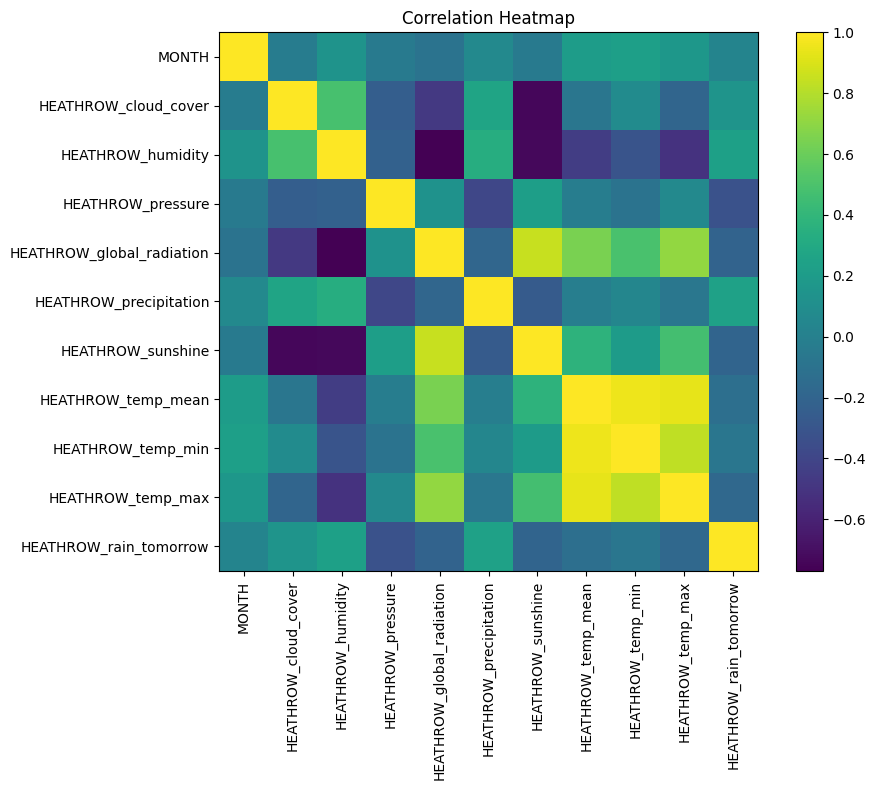

In [20]:
# Class balance
y.value_counts().plot(kind="bar")
plt.title("Rain Tomorrow Class Distribution")
plt.xlabel("Class (0 = no rain, 1 = rain)")
plt.ylabel("Count")
plt.show()

# Monthly probability of rain tomorrow
monthly_rain = df.groupby("MONTH")["HEATHROW_rain_tomorrow"].mean()
monthly_rain.plot(kind="bar")
plt.title("Average Probability of Rain Tomorrow by Month")
plt.xlabel("Month")
plt.ylabel("P(rain tomorrow)")
plt.show()

# Correlation heatmap
corr_cols = feature_cols + ["HEATHROW_rain_tomorrow"]
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()
